In [1]:
import numpy as np
import os
import os.path
import src.visualization.display as dsp
import netCDF4 as nc
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import scipy.ndimage.morphology as scm
import importlib
import matplotlib.ticker as mtick
importlib.reload(dsp)

/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.visualization.display' from '/Users/coulaud/Documents/DL-normalization/src/visualization/display.py'>

In [2]:
os.getcwd()

'/Users/coulaud/Documents/DL-normalization/notebooks'

In [2]:
norm_std = 110439.79485414618
norm_mean = 525208.1680871231

In [3]:
model = cnn.CNN.load_from_checkpoint("../../epoch=2757-val_loss=0.00001.ckpt")


In [5]:
X=np.load("../data/processed/isotropic_noise100_samples_standardize/train/X/sphere_polecontinent16.npz")['arr_0']
X=torch.from_numpy(X[np.newaxis,:]).float()
print(X.shape)
X = X[:,:,10:-10,:]

#plt.imshow(X[0,0,:,:])

#X=X
Y=np.load("../data/processed/isotropic_noise100_samples_standardize/train/Y/sphere_polecontinent16_norm_coeffs.npz")['arr_0']
mask = np.where(Y[10:-10,:]==0,True,False)
Y = Y[10:-10,:]*norm_std + norm_mean
Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*norm_std + norm_mean
#mask = np.where(Y==0,True,False)
eps = (Y_pred**2 - Y**2)/Y**2
eps = np.ma.masked_array(eps, mask)

torch.Size([1, 3, 180, 448])


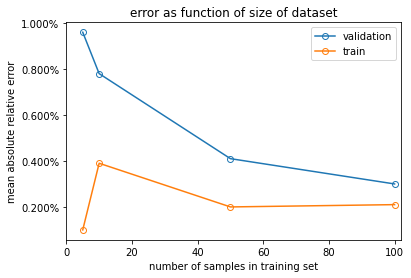

In [6]:
fig,ax = plt.subplots()
ns = [5,10,50,100]
val_error = [0.0096,0.0078,0.0041,0.003]
train_error = [0.001,0.0039,0.002,0.0021]
ax.plot(ns,val_error,"o-",markerfacecolor='none',label="validation",)
ax.plot(ns,train_error,"o-",markerfacecolor='none',label="train")
#ax.semilogy(ranges[:-1],means2,"o-",markerfacecolor='none',label="ronneberger")
#ax.semilogy(ranges[:-1],means3,"o-",markerfacecolor='none',label="pix2pix5 + 2x2conv normalised")
ax.set_xlim(0,102)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=3, symbol='%', is_latex=False))
ax.set_ylabel("mean absolute relative error")
ax.set_xlabel("number of samples in training set")
ax.set_title("error as function of size of dataset")
ax.legend()

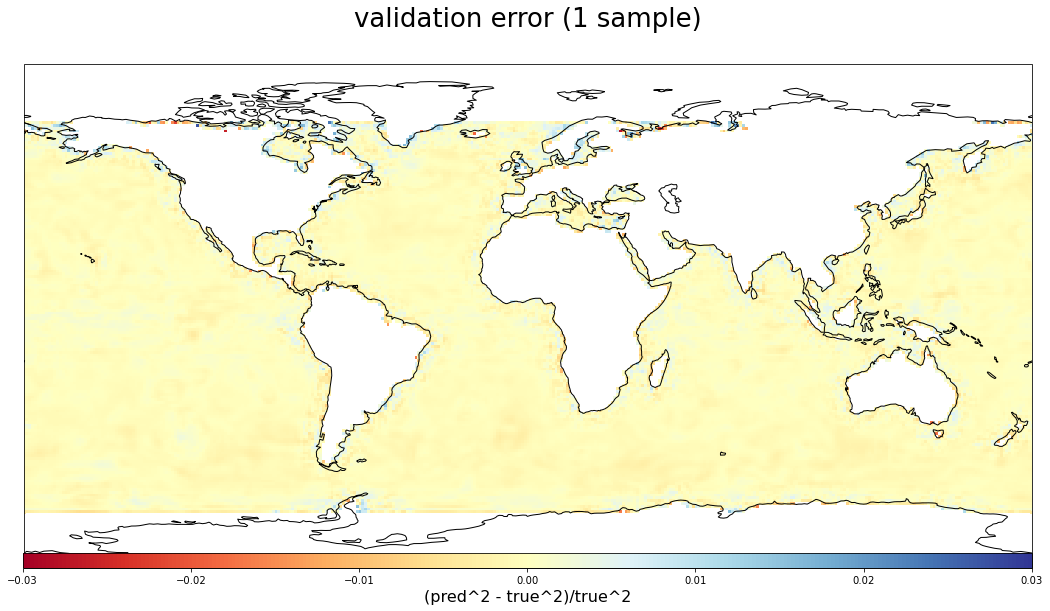

mean:  0.0011332357213064282
max:  0.02746243281536265


In [7]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(eps, lon2d, lat2d,vmin=-0.03,vmax=0.03,cmap="RdYlBu",
                     cmap_title="(pred^2 - true^2)/true^2",title="validation error (1 sample)")
print("mean: ",np.mean(np.abs(eps)))
print("max: ",np.max(np.abs(eps)))

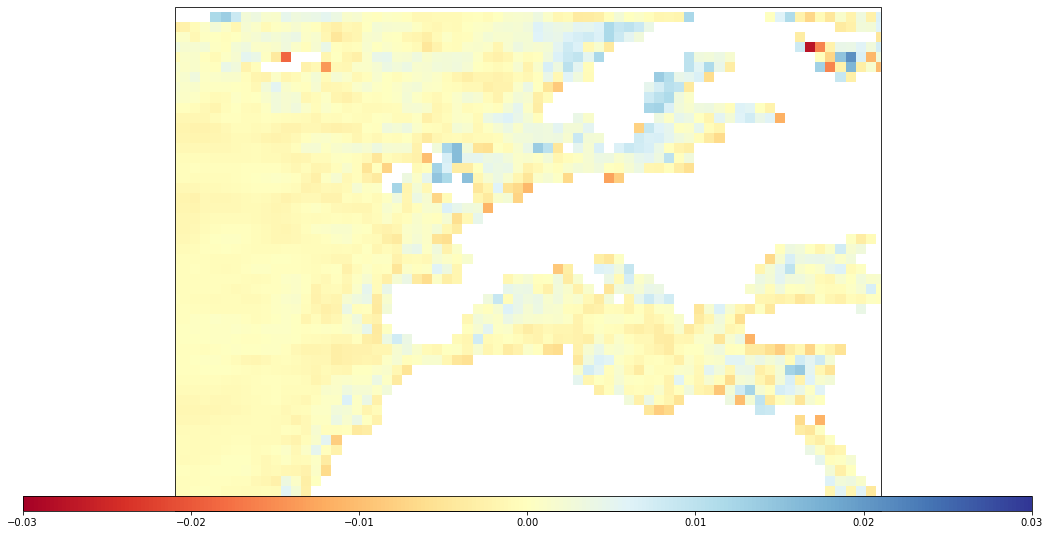

In [8]:
dsp.plot_error_region(np.ma.masked_array(eps, mask), 
                       lon2d, lat2d,region="europe",cmap="RdYlBu",vmin=-0.03,vmax=0.03)

# Train bias

In [16]:
std = norm_std
mean = norm_mean
dir_path="../data/processed/isotropic_noise100_samples_standardize/train/X/"
eps = np.empty((len(os.listdir(dir_path)),160,360))
for i,file_list in enumerate(os.listdir(dir_path)):
    X=np.load(dir_path+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = X[:,:,10:-10,:]
    Y=np.load("../data/processed/isotropic_noise100_samples_standardize/train/Y/" + file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    if i==0:
        mask = np.where(Y[10:-10,:]==0,True,False) 
    Y = Y[10:-10,:]*std + mean
    Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*std + mean
    aux = (Y_pred**2 - Y**2)/Y**2
    eps[i,:,:] = np.ma.masked_array(aux, mask)

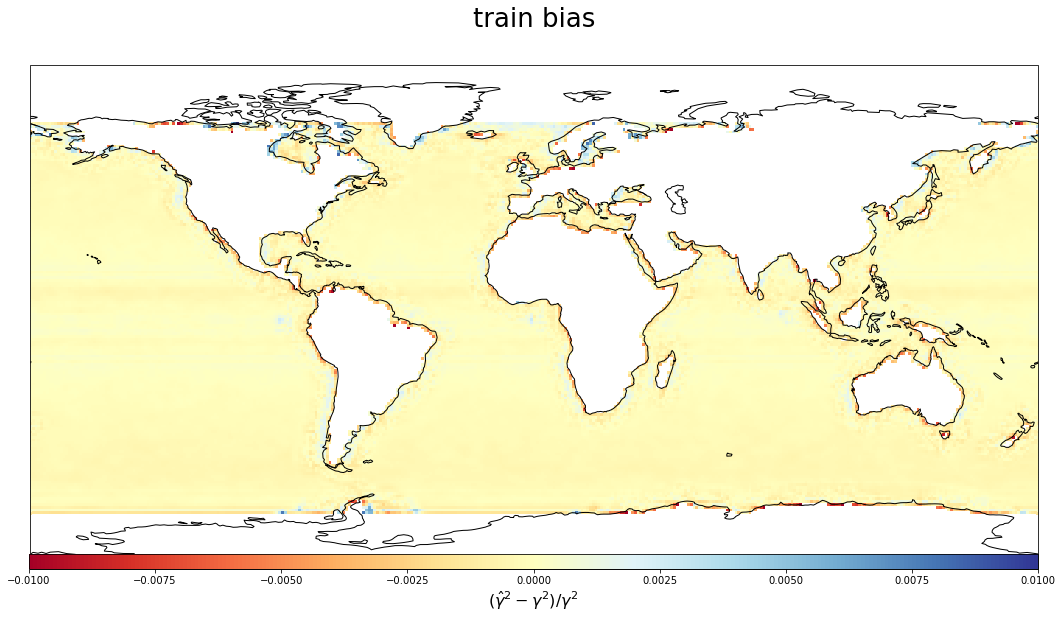

mean:  0.0004712898212169621
max:  0.0235400195087507


In [22]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(np.ma.masked_array(np.mean(eps,axis=0), mask), lon2d, lat2d,vmin=-0.01,vmax=0.01,cmap="RdYlBu",
                     cmap_title="($\hat{\gamma}^2 - \gamma^2)/\gamma^2$",title="train bias")
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))

## Validation bias

In [23]:
std = norm_std
mean = norm_mean
dir_path="../data/processed/isotropic_noise99_samples_standardize/valid/X/"
eps = np.empty((len(os.listdir(dir_path)),160,360))
for i,file_list in enumerate(os.listdir(dir_path)):
    X=np.load(dir_path+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = X[:,:,10:-10,:]
    Y=np.load("../data/processed/isotropic_noise99_samples_standardize/valid/Y/" + file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    if i==0:
        mask = np.where(Y[10:-10,:]==0,True,False) 
    Y = Y[10:-10,:]*std + mean
    Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*std + mean
    aux = (Y_pred**2 - Y**2)/Y**2
    eps[i,:,:] = np.ma.masked_array(aux, mask)

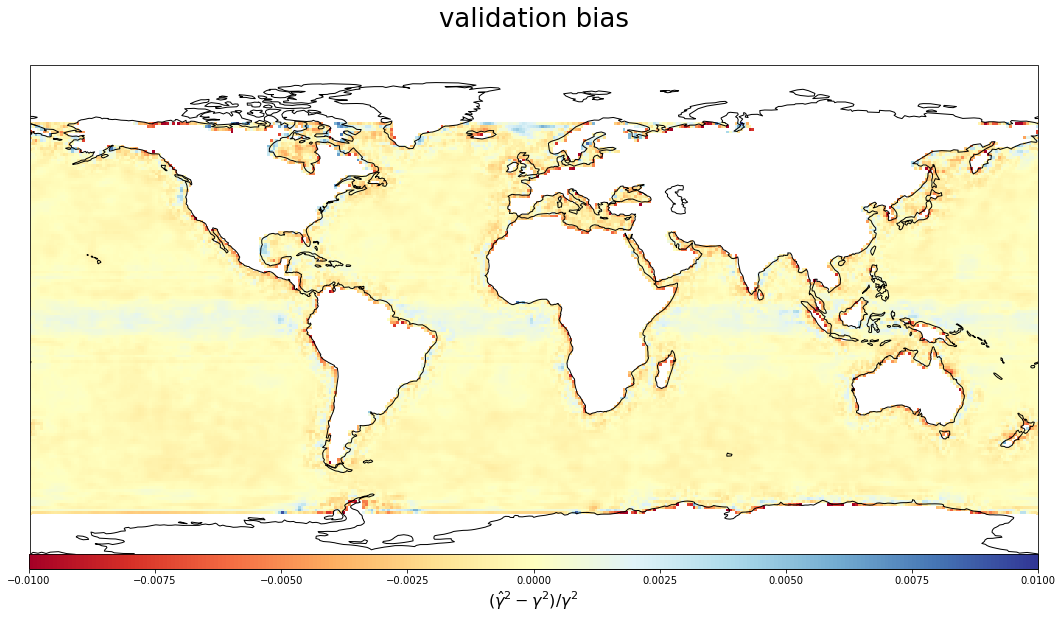

mean:  0.000679732407747505
max:  0.02142746011945495


In [34]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(np.ma.masked_array(np.mean(eps,axis=0), mask), lon2d, lat2d,vmin=-0.01,vmax=0.01,cmap="RdYlBu",
                     cmap_title="($\hat{\gamma}^2 - \gamma^2)/\gamma^2$",title="validation bias")
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))

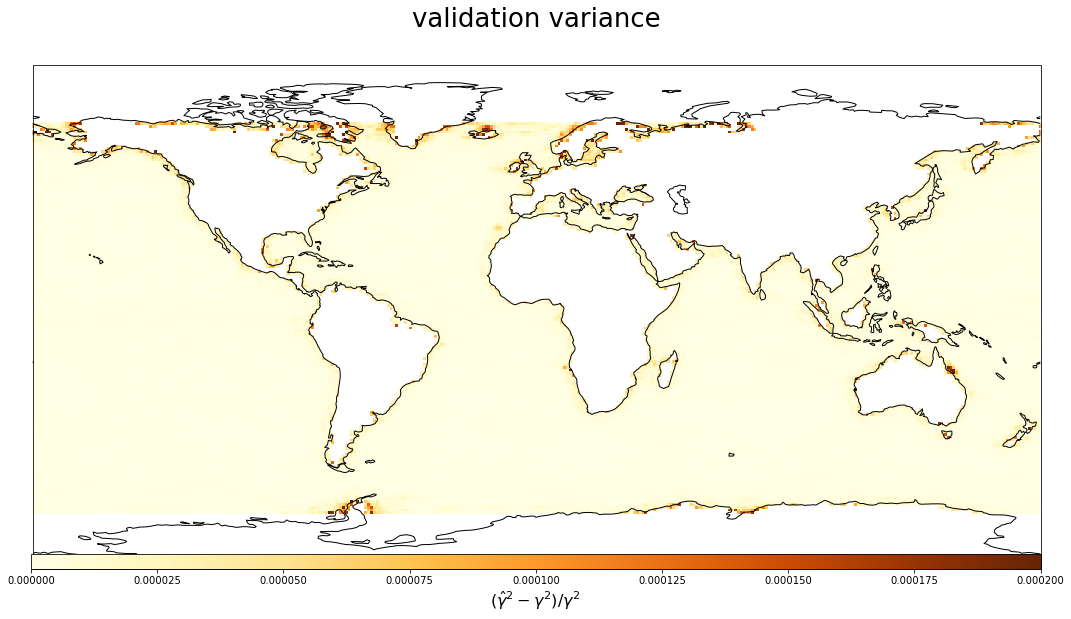

mean:  5.34416002863369e-06
max:   0.0004671429806586597
min:   2.4957478997853718e-08


In [46]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(np.ma.masked_array(np.sum((eps - np.mean(eps,axis=0))**2, axis=0)/10, mask), lon2d, lat2d,vmin=0,vmax=0.0002,cmap="YlOrBr",
                     cmap_title="($\hat{\gamma}^2 - \gamma^2)/\gamma^2$",title="validation variance")
print("mean: ",np.mean(np.ma.masked_array(np.sum((eps - np.mean(eps,axis=0))**2, axis=0)/10, mask)))
print("max:  ",np.max(np.ma.masked_array(np.sum((eps - np.mean(eps,axis=0))**2, axis=0)/10, mask)) )
print("min:  ",np.min(np.ma.masked_array(np.sum((eps - np.mean(eps,axis=0))**2, axis=0)/10, mask)) )